<a href="https://colab.research.google.com/github/francescodisalvo05/66DaysOfData/blob/main/Labs/Lab_02_Word_and_Sentence_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep Natural Language Processing @ PoliTO**

---


**Teaching Assistant:** Moreno La Quatra

**Practice 2:** Word and Sentence Embeddings

## Word Embedding 

![](https://qph.fs.quoracdn.net/main-qimg-3e812fd164a08f5e4f195000fecf988f)


**Key takeaways** from lessons and in-class practices:
- Word embeddings are able to map words into a semantic-aware vector space
- There are multiple architectures for the generation of word embeddings
- Each architecture has its advantages and disadvantages
- Word embedding evaluation could be intrinsic (intermediate tasks) or extrinsic (downstream task)
- It is possible to use pre-trained word embedding models or use large amount of text to train it from scratch


### **Question 1**

Train a new Word2Vec model using gensim with the text8 corpus available in the python package ([reference](https://radimrehurek.com/gensim/downloader.html)). Compute the training time for the model and store it for subsequent steps.

In [ ]:
! pip install --upgrade gensim

In [ ]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip text8

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec

dataset = api.load("text8") 

[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
%%time
model = Word2Vec(dataset) # default values
model.save("word2vec.model")

CPU times: user 4min 18s, sys: 2.34 s, total: 4min 20s
Wall time: 2min 21s


### **Question 2**:
Perform intrinsic evaluation of the model for the task of word analogy by exploiting the data collection available [here](https://raw.githubusercontent.com/MorenoLaQuatra/DeepNLP/main/practices/P2/google_analogies.csv). 

1. read CSV file
2. group analogy entries by type (column: `type`)
3. for each type entry (**in the lab, just set type="family"** to reduce the required time) use the first 3 word vectors to compute the fourth
    - Entry: `Athens,Greece,Baghdad,Iraq`
    - `v(Greece) - v(Athens) + v(Baghdad) = res_v` 
    - Get the most similar vectors to `res_v`
    - Compute in how many cases the correct word is among the top K (if `v[Iraq]` is among the K most similar words) with `K = 1, 3, 5, 10`

$top(k) = \dfrac{\sum_{i=1}^{N} f(i)}{|E|}$

where $f(i) = 1$ if the target word is among the top k and $f(i) = 0$ otherwise.

$|E|$ is the total number of entries for the considered type.

**Notes:**
1. Try with the model trained on `text8`, is there any issue?
2. Test the model trained on Google News available in gensim.



In [ ]:
# Using Word2Vec trained on "text8" we obtain an "out of vocabulary" error
# whereas the one trained on "Google News" was smooth but slower

In [ ]:
%%capture
! wget https://raw.githubusercontent.com/MorenoLaQuatra/DeepNLP/main/practices/P2/google_analogies.csv

In [ ]:
# Executing this cell could take ~5 minutes
import gensim.downloader
w2v_google_news_model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import pandas as pd

# read CSV file
data_analogies = pd.read_csv('google_analogies.csv').drop(columns=["Unnamed: 0"])

# filter only "family" type
family_analogies = data_analogies[data_analogies["type"] == "family"].copy()

In [ ]:
# get the embeddings for word1, word2 and word3 -> let us call v1,v2 and v3
def getV4(row):
  
  # compute the algebraic operation -> v4 is a row vector
  v4 = w2v_google_news_model[row["word2"]] - w2v_google_news_model[row["word1"]] + w2v_google_news_model[row["word3"]]

  # get the 10 most similar word to v4
  top10 = w2v_google_news_model.most_similar(v4)[:10]

  # return only the list of top10 values (without the scores)
  return [ x[0] for x in top10 ]

family_analogies["v4"] = family_analogies.apply(getV4, axis=1)

In [ ]:
family_analogies.head()

In [ ]:
# now count the number of correct results among the top k = [1,3,5,10] scores

# I could use again the apply method and add 4 more columns with 1 if 
# it is in the top k and 0 otherwise, but it would too heavy
# therefore I will go with iterrows

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

def evaluate_top_values(df):

  top_1 = top_3 = top_5 = top_10 = 0

  for index, row in df.iterrows():

    target = row["target"]
    top10 = row["v4"]

    if target in top10:
      top_10 += 1

    if target in top10[:5]:
      top_5 += 1

    if target in top10[:3]:
      top_3 += 1

    if target == top10[0]:
      top_1 += 1

  acc_1 = top_1/len(df)
  acc_3 = top_3/len(df)
  acc_5 = top_5/len(df)
  acc_10 = top_10/len(df)

  plt.plot([1,3,5,10],[acc_1,acc_3,acc_5,acc_10])
  plt.xlabel("Top K")
  plt.xticks([1,3,5,10])
  plt.ylabel("Accuracy")
  

In [ ]:
evaluate_top_values(family_analogies)

### **Question 3:**

Train a new FastText model using gensim with text8 corpus available in the python package ([reference](https://radimrehurek.com/gensim/downloader.html)). Compute the training time for the model and store it for subsequent steps. 

- Is there any significant difference in training time if compared with Word2Vec training?

In [ ]:
import gensim.downloader as api
from gensim.models import FastText

dataset_text8 = api.load("text8") 

# since the Object 'Dataset' has no "len" attributes,
# I will manually calculate it
len_dataset = 0
for _ in dataset_text8:
  len_dataset += 1


model_fasttext = FastText(window=3, min_count=1)
model_fasttext.build_vocab(dataset_text8)
model_fasttext.train(dataset_text8, total_examples=len_dataset, epochs=1)

# it is much much slower and there are much more stored informations

(12818778, 17005207)

### **Question 4:**
Score the FastText model by exploiting the same methodology presented in Q2. 

**Notes:**
- Is there any issue similar to Word2Vec model?
- Test the model trained on Wikipedia+News available in gensim.

In [ ]:
%%capture
! wget https://raw.githubusercontent.com/MorenoLaQuatra/DeepNLP/main/practices/P2/google_analogies.csv

In [ ]:
import pandas as pd
import gensim.downloader

fasttext_wiki_news_model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

# read CSV file
data_analogies = pd.read_csv('google_analogies.csv').drop(columns=["Unnamed: 0"])

# filter only "family" type
family_analogies = data_analogies[data_analogies["type"] == "family"].copy()

In [ ]:
def getV4_fasttext(row):
  
  # compute the algebraic operation -> v4 is a row vector
  v4 = fasttext_wiki_news_model[row["word2"]] - fasttext_wiki_news_model[row["word1"]] + fasttext_wiki_news_model[row["word3"]]

  # get the 10 most similar word to v4
  top10 = fasttext_wiki_news_model.most_similar(positive=[v4], topn=10)

  # return only the list of top10 values (without the scores)
  return [ x[0] for x in top10 ]

family_analogies["v4"] = family_analogies.apply(getV4_fasttext, axis=1)

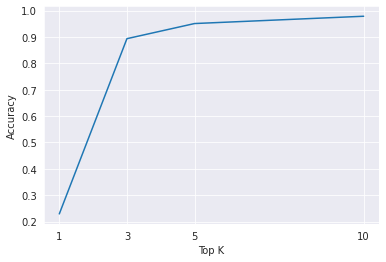

In [ ]:
evaluate_top_values(family_analogies)

### **Question 5** (optional) 
Evaluate Word2Vec and FastText models  on the analogy task for the whole dataset (include all analogy types).

In [ ]:
# Your code here

## Sentence Embeddings

Key takeaways from lessons and in-class practices:
- Doc2Vec is an extension of the Word2Vec framework
- It incorporate Document ID to obtain a more accurate representation of a document/paragraph
- Training document vectors are pre-computed, however you can infer vectors for new documents
- InferSent exploit a deep learning architecture to supervisedly learn sentence representations
- InferSent vectors could exploit both Word2Vec or FastText as word embedding models.

### **Question 6:**

Train a Doc2Vec model using gensim with text8 corpus. Compute the training time for the model and store it for subsequent steps.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api


dataset_text8 = api.load("text8") 

tagged_text8 = [TaggedDocument(words=tokens, tags=[str(idx)]) for idx, tokens in enumerate(dataset_text8)]

In [ ]:
max_epochs = 10
emb_size = 200
alpha = 0.01

model = Doc2Vec(documents=tagged_text8, 
                vector_size=emb_size, 
                alpha=alpha,
                min_alpha=0.0001,
                min_count=1,
                dm=1,
                epochs=max_epochs)

In [ ]:
model.save("d2v.model")

### **Question 7 (qualitative Evaluation)**
Perform some qualitative experiments by computing the cosine similarities between sentences composed by yourself.

In [ ]:
vec_1 = model.infer_vector(["I","love","studying","data", "science"])
vec_2 = model.infer_vector(["I", "do","not","like", "studying", "arts"])

print(cosine_similarity(vec_1.reshape(1,-1),vec_2.reshape(1,-1)))

### **Question 8** (Extrinsic Evaluation)

Extrinsic evaluation measure performance of the word/sentence/paragraph embedding model for a downstream NLP task (e.g., Text Classification).

We can use different configuration, training corpora or even different models to build a complete architecture for the task at hand.

For this practice we use the text classification dataset available [here](https://github.com/MorenoLaQuatra/DeepNLP/blob/main/practices/P2/news_headline_classification.csv) - [source: Kaggle](https://www.kaggle.com/rmisra/news-category-dataset)

**Note:** consider using just the first 10.000 headlines to reduce runtime during the lab.

Compute the accuracy of 3 classification models each one built with one of the models introduced in this practice:
- Word2Vec model pretrained on Google News corpus
- FastText model pretrained on Wikipedia+News corpus
- **[Optional]** Doc2Vec model pretrained on Text8 corpus
- **[Optional]** InferSent pretrained model (v2) - [reference](https://github.com/facebookresearch/InferSent)

The procedure to create a classification system is sketched below:
1. Choose a machine learning (multi-class) classifier (e.g., MLP)
2. Split the data collection in train/test (80%/20%)
3. Use text vectors obtained by pretrained model as input of the classifier
4. Measure the accuracy of the classification system
5. Repeat step 3-4 using different embedding models 


**Note:** You need to choose an aggregation function (e.g., average) to obtain sentence embeddings from word vectors.

Which model has better performance? Report the performance of each variant of the classification system.

In [ ]:
!wget https://raw.githubusercontent.com/MorenoLaQuatra/DeepNLP/main/practices/P2/news_headline_classification.csv

--2021-10-24 06:25:45--  https://raw.githubusercontent.com/MorenoLaQuatra/DeepNLP/main/practices/P2/news_headline_classification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15212143 (15M) [text/plain]
Saving to: ‘news_headline_classification.csv’

news_headline_class 100%[===================>]  14.51M  --.-KB/s    in 0.1s    

2021-10-24 06:25:46 (143 MB/s) - ‘news_headline_classification.csv’ saved [15212143/15212143]



In [51]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import gensim.downloader

import nltk
from nltk.tokenize import word_tokenize

import re

nltk.download('punkt')

random_state = 42

def classify(X,y):

  X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2)

  model = MLPClassifier() 
  model.out_activation_ = 'softmax' # softmax because we need a multi class classifier
  
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  
  acc = accuracy_score(y_test, y_pred)

  print(f"Accuracy: {acc}")


df_headlines = pd.read_csv('news_headline_classification.csv').iloc[:10000].drop(columns=['Unnamed: 0'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_headlines.head()

,category,headline
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [ ]:
def make_sentence_embeddings(df,model):
  
  sentence_embeddings = []

  for index, row in df.iterrows():

    # remove punctuation 
    cleaned_text = re.sub(r'[^\w\s]', '', row["headline"])

    # tokenize 
    tokens = word_tokenize(cleaned_text.lower())

    # sum along each component of each word and divide by the length
    # -> feature averaging  
    curr_embedding = np.sum(model[tokens],axis=0) / len(tokens)

    sentence_embeddings.append(curr_embedding)

  return sentence_embeddings

**Word2Vec + Average aggregation function**

In [ ]:
w2v_news = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
embeddings_word2vec = make_sentence_embeddings(df_headlines, model)

# to do : manage out of vocabulary error!

**FastText + Average aggregation function**

In [ ]:
ft_wiki_news = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [ ]:
sentence_embeddings = []

for index, row in df.iterrows():

  # remove punctuation 
  cleaned_text = re.sub(r'[^\w\s]', '', row["headline"])

  # tokenize 
  tokens = word_tokenize(cleaned_text.lower())

  # sum along each component of each word and divide by the length
  # -> feature averaging  
  curr_embedding = np.sum(ft_wiki_news[tokens],axis=0) / len(tokens)

  sentence_embeddings.append(curr_embedding)

In [ ]:
embeddings_ft = make_sentence_embeddings(df_headlines,ft_wiki_news)

# to do : manage out of vocabulary error!

classify(embeddings_ft, df_headlines["category"])

**Doc2Vec (Text8)**

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from sklearn.metrics.pairwise import cosine_similarity

import gensim.downloader as api

text8 = api.load("text8")
dataset_text8 = [data for data in text8]

# create a tagged document based on text8 corpura (as requested)
tagged_data = [TaggedDocument(words=words, tags=[i]) for i,words in enumerate(dataset_text8)]

In [37]:
%%time
d2v_text8 = Doc2Vec(document=tagged_data,
                alpha=0.1,
                min_alpha=0.0001,
                min_count=1,
                dm=1,
                epochs=10,
                vector_size=50)

d2v_text8.build_vocab(tagged_data)
d2v_text8.train(tagged_data, total_words=model.corpus_count, epochs=model.epochs)

CPU times: user 2min 1s, sys: 1.81 s, total: 2min 3s
Wall time: 1min 35s


In [52]:
X_d2v = []

for i, row in df_headlines.iterrows():
  X_d2v.append(d2v_text8.infer_vector(word_tokenize(row["headline"].lower())))

In [75]:
classify(X_d2v,df_headlines["category"])

Accuracy: 0.3605


**InferSent**

In [ ]:
%%capture
# InferSent download required files

! mkdir fastText
! curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
! unzip fastText/crawl-300d-2M.vec.zip -d fastText/
! mkdir encoder
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
! git clone https://github.com/facebookresearch/InferSent.git

In [ ]:
from InferSent.models import InferSent
import torch
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [ ]:
# Your code here